In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


In [5]:
# Load Data
df = pd.read_excel('EastWestAirlines.xlsx', sheet_name="data")

In [6]:
df.shape

(3999, 12)

In [7]:
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [ ]:
# to check nulls
df.isnull().sum()

ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [ ]:
# to check duplicates
df.duplicated().sum()

np.int64(0)

In [16]:
# Remove ID column
features = df.drop(columns=['ID#'])

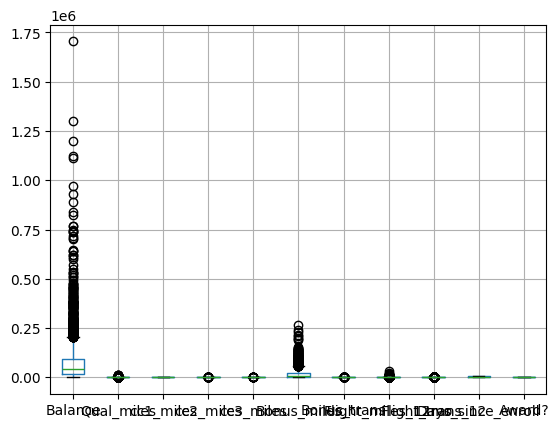

In [17]:
features.boxplot()
plt.show()

In [18]:
# Outlier capping (simple IQR method)
def cap_outliers(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return col.clip(lower, upper)

features = features.apply(cap_outliers)

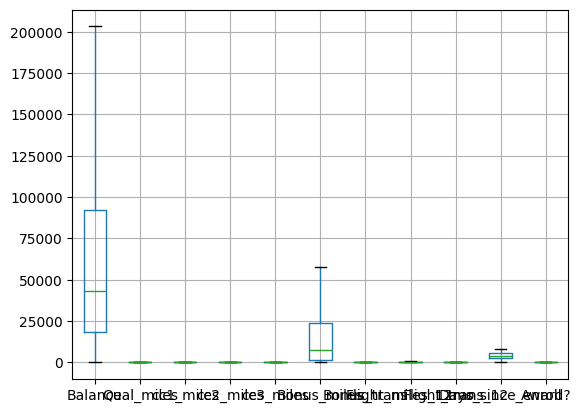

In [19]:
features.boxplot()
plt.show()

In [ ]:
# Scaling
std_sca = StandardScaler()
features = pd.DataFrame(std_sca.fit_transform(features), columns=features.columns)
features.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.607258,0.0,-0.769578,0.0,0.0,-0.843091,-1.148854,-0.604313,-0.626143,1.395454,-0.766919
1,-0.758947,0.0,-0.769578,0.0,0.0,-0.840822,-1.039133,-0.604313,-0.626143,1.379957,-0.766919
2,-0.382070,0.0,-0.769578,0.0,0.0,-0.624581,-0.819689,-0.604313,-0.626143,1.411920,-0.766919
3,-0.835106,0.0,-0.769578,0.0,0.0,-0.825052,-1.148854,-0.604313,-0.626143,1.372208,-0.766919
4,0.579265,0.0,1.409471,0.0,0.0,1.543191,1.594189,2.034489,2.020176,1.363975,1.303918


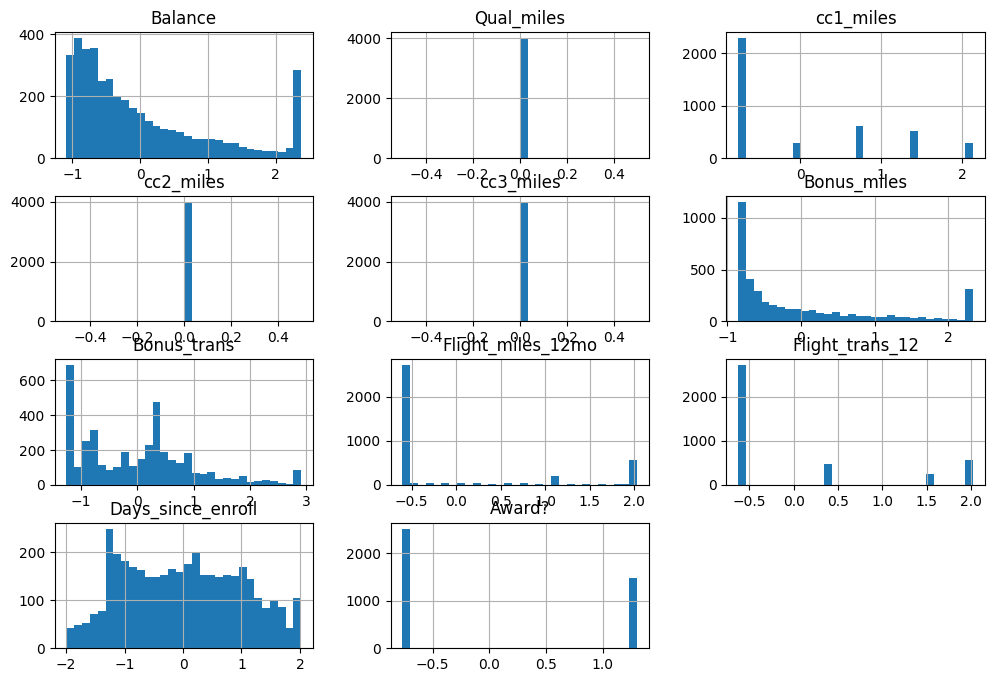

In [21]:
#Histogram
features.hist(bins=30, figsize=(12,8))
plt.show()

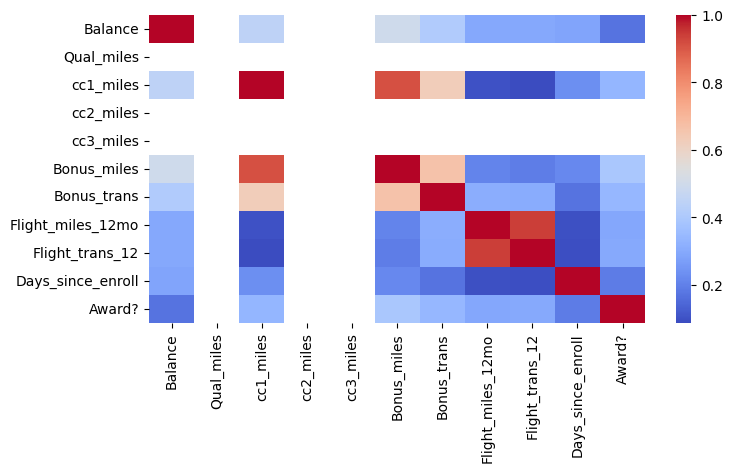

In [24]:
#Correlation Heatmap
plt.figure(figsize=(8,4))
sns.heatmap(features.corr(), cmap='coolwarm')
plt.show()

#### K-MEANS 

  File "C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[31992.000000000004, 22258.774283802217, 17645.544659962226, 15198.433669413045, 13705.295394747094, 12483.135244227366, 11778.833477856386, 10774.635527291752, 10256.995184999389, 9622.607810969595]


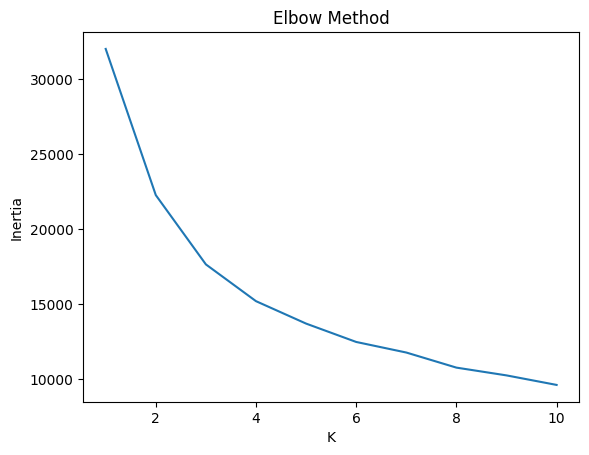

In [25]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)
print(inertia)

plt.plot(range(1, 11), inertia)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [26]:
#K-Means Clustering
kmeans = KMeans(n_clusters=4)
cluster_km = kmeans.fit_predict(features)
df['kmeans_cluster'] = cluster_km
np.unique(cluster_km)

array([0, 1, 2, 3], dtype=int32)

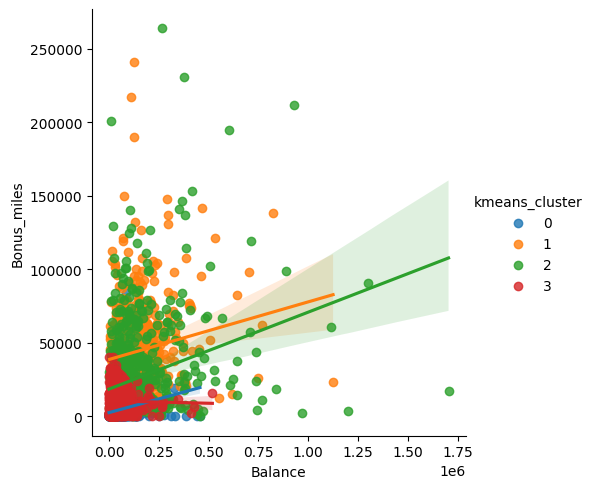

In [27]:
#K-Means Visualization
sns.lmplot(data=df, x='Balance', y='Bonus_miles', hue='kmeans_cluster')
plt.show()

In [28]:
#K-Means Silhouette Score
silhouette_score(features, cluster_km)

0.2604452908069296

#### Hierarchical Clustering Cell

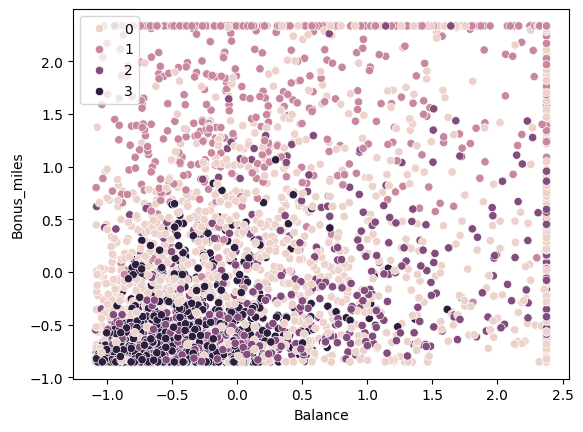

In [40]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
hc_labels = hc.fit_predict(features)
df['hierarchical_cluster'] = hc_labels

np.unique(hc_labels)

sns.scatterplot(data=features, x='Balance', y='Bonus_miles', hue=hc_labels)
plt.show()

#### DBSCAN

In [29]:
#DBSCAN Parameter Search
eps_vals = [0.1,0.2,0.3,0.4,0.5]
min_samples_vals = range(2, 11)

output = []
for e in eps_vals:
    for m in min_samples_vals:
        labels = DBSCAN(eps=e, min_samples=m).fit(features).labels_
        score = silhouette_score(features, labels)
        output.append([e, m, score])

print(output)

df_params = pd.DataFrame(output, columns=['eps','min_samples','score'])
df_params[df_params.score == df_params.score.max()]

[[0.1, 2, -0.45539373967697333], [0.1, 3, -0.31781598594964144], [0.1, 4, -0.24327682083599053], [0.1, 5, -0.22764758853299857], [0.1, 6, -0.19507249548757383], [0.1, 7, -0.2019080571485221], [0.1, 8, -0.2020597004106827], [0.1, 9, -0.2097541806556396], [0.1, 10, -0.20913754193595394], [0.2, 2, -0.501179095017923], [0.2, 3, -0.48994978138671413], [0.2, 4, -0.33414001118398856], [0.2, 5, -0.23560443337089473], [0.2, 6, -0.23777614665318864], [0.2, 7, -0.2356872355459249], [0.2, 8, -0.22729427045885514], [0.2, 9, -0.22575384417165015], [0.2, 10, -0.19373188312064646], [0.3, 2, -0.359426075274148], [0.3, 3, -0.41497878445460235], [0.3, 4, -0.41996977308923455], [0.3, 5, -0.35035425689789385], [0.3, 6, -0.322167016670529], [0.3, 7, -0.15516372099554732], [0.3, 8, -0.17129395187519547], [0.3, 9, -0.1532038369695963], [0.3, 10, -0.08081005512417376], [0.4, 2, -0.26732159941641603], [0.4, 3, -0.2979416413564941], [0.4, 4, -0.31777897148167566], [0.4, 5, -0.2804885755879636], [0.4, 6, -0.27772

,eps,min_samples,score
26,0.3,10,-0.08081


In [36]:
#DBSCAN Model
db = DBSCAN(eps=1.3, min_samples=5)
labels_db = db.fit_predict(features)
df['dbscan_cluster'] = labels_db
np.unique(labels_db)

array([-1,  0,  1])

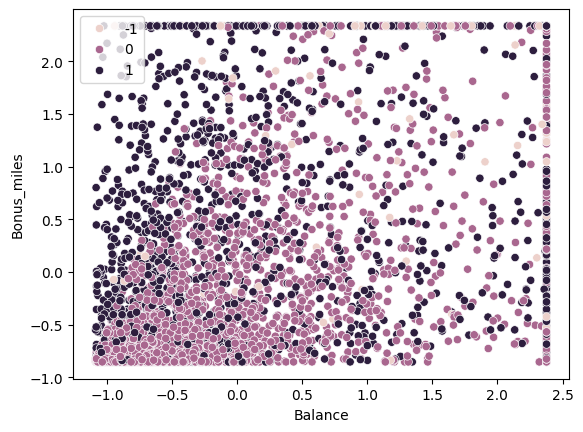

In [37]:
#DBSCAN Visualization
sns.scatterplot(data=features, x='Balance', y='Bonus_miles', hue=labels_db)
plt.show()

In [38]:
#DBSCAN Silhouette Score
silhouette_score(features, labels_db)

0.20728478509664286

In [39]:
# Cluster Analysis
np.unique(cluster_km)
np.unique(labels_db)

array([-1,  0,  1])

#### Cluster Analysis and Interpretation

**K-Means Clustering:**
- The model formed 4 clusters.
- The clusters show differences mainly in Balance and Bonus_miles.
- Customers with higher Balance and Bonus_miles fall into separate groups.

**Hierarchical Clustering:**
- Also forms 4 clusters using distance-based grouping.
- Shows similar separation patterns as K-Means.

**DBSCAN:**
- DBSCAN created 2 clusters and some noise points (-1).
- Due to dataset density, DBSCAN finds limited cluster separation.

**Overall Observations:**
- K-Means and Hierarchical give clear cluster groups.
- DBSCAN is less effective for this dataset but still identifies dense regions and noise.
